In [1]:
from typing import Annotated
from typing_extensions import TypedDict

In [2]:
## Working With Tools

from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun

## Arxiv And Wikipedia tools
arxiv_wrapper=ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=300)
arxiv_tool=ArxivQueryRun(api_wrapper=arxiv_wrapper)

api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=300)
wiki_tool=WikipediaQueryRun(api_wrapper=api_wrapper)

In [3]:
wiki_tool.invoke("who is Sharukh Khan")

'Page: Shah Rukh Khan\nSummary: Shahrukh Khan (pronounced [ˈʃɑːɦɾʊx xɑːn] ; born 2 November 1965), also known by the initialism SRK, is an Indian actor and film producer who works in Hindi cinema. Referred to in the media as the "Baadshah of Bollywood" and "King Khan", he has appeared in more than 100'

In [4]:
arxiv_tool.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with "

In [22]:
tools=[wiki_tool, arxiv_tool]

In [23]:
## Langgraph Application
from langgraph.graph.message import add_messages
class State(TypedDict):
  messages:Annotated[list,add_messages]

In [24]:
from langgraph.graph import StateGraph,START,END

In [25]:
graph_builder= StateGraph(State)


In [26]:
from langchain_groq import ChatGroq

In [27]:
from langchain import hub
from langchain.agents import create_structured_chat_agent
from tools.initialize_cerebras import init_cerebras

# Get the prompt to use - you can modify this!
prompt = hub.pull("hwchase17/structured-chat-agent")

# Choose the LLM that will drive the agent
client, llm = init_cerebras()



In [28]:
llm_with_tools=llm.bind_tools(tools=tools)

In [29]:
def chatbot(state:State):
  return {"messages":[llm_with_tools.invoke(state["messages"])]}

In [30]:
from langgraph.prebuilt import ToolNode,tools_condition

In [31]:
graph_builder.add_node("chatbot",chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START,"chatbot")


In [32]:
graph=graph_builder.compile()

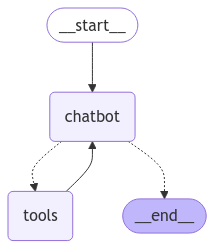

In [33]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [34]:
from langchain_core.messages import HumanMessage
user_input="Hi there!, My name is John"

events=graph.stream(
     {"messages": [HumanMessage(content=user_input)]},stream_mode="values"
)

for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there!, My name is John
================================== Ai Message ==================================

Hello John, it's nice to meet you. Is there something I can help you with or would you like to chat?


In [36]:
user_input = "what is RLHF. look in arxiv"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]},stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is RLHF. look in arxiv
================================== Ai Message ==================================
Tool Calls:
  arxiv (6f918c3d8)
 Call ID: 6f918c3d8
  Args:
    query: RLHF
================================= Tool Message =================================
Name: arxiv

Published: 2024-07-15
Title: Exploration-Driven Policy Optimization in RLHF: Theoretical Insights on Efficient Data Utilization
Authors: Yihan Du, Anna Winnicki, Gal Dalal, Shie Mannor, R. Srikant
Summary: Reinforcement Learning from Human Feedback (RLHF) has achieved impressive
empirical successes 
================================== Ai Message ==================================

RLHF stands for Reinforcement Learning from Human Feedback.
